MSE : 199349482.43524653
RMSE: 14119.117622402844
Mean Squared Error: 103585418.61539614
MSE : 103585418.61539614
RMSE: 10177.692204787692
Cross-Validation RMSE for 5 folds:
[10538.19392148 10336.38550607  9563.51833808 10232.87262773
 10411.13188287]
Average RMSE: 10216.420455244992
Best alpha: {'ridge__alpha': 0.1}
Best MSE: 100424387.62899955
Best RMSE: 10021.196915987608

Top 15 positive categorical coefficients:


,feature,coefficient
7,cylinders_12 cylinders,32508.006462
14,fuel_diesel,10558.317041
6,cylinders_10 cylinders,6827.154499
4,condition_new,6046.196330
24,type_convertible,5416.713181
28,type_offroad,4153.601687
82,state_wa,4045.934205
79,state_ut,3921.386758
25,type_coupe,3475.457755
46,state_hi,3353.788915



Top 15 negative categorical coefficients:


,feature,coefficient
31,type_sedan,-2425.882570
41,state_ct,-2473.048546
1,condition_fair,-2870.337224
20,drive_fwd,-2966.897158
34,type_wagon,-3389.053015
17,fuel_hybrid,-3941.208369
26,type_hatchback,-4677.470536
16,fuel_gas,-4718.291330
11,cylinders_6 cylinders,-4736.258321
5,condition_salvage,-5346.269687


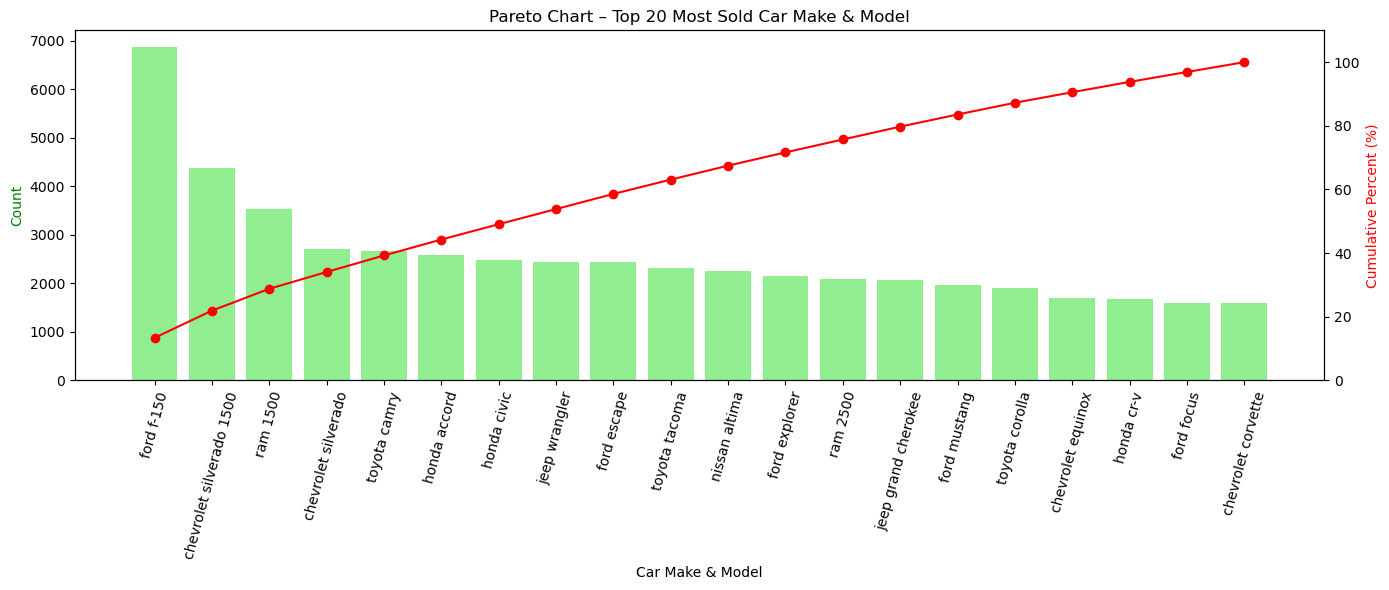

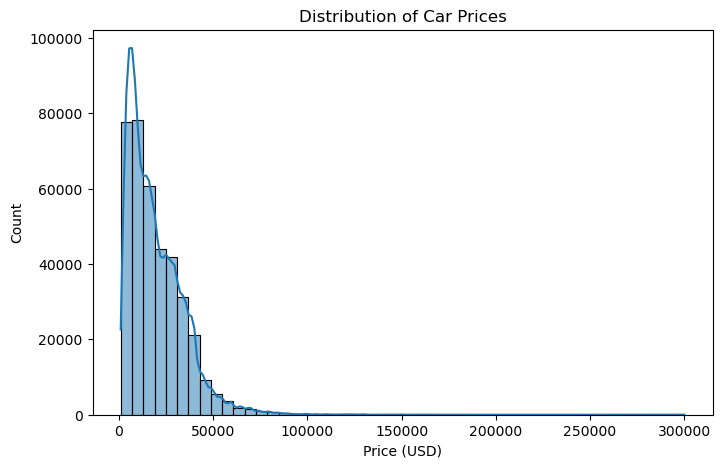

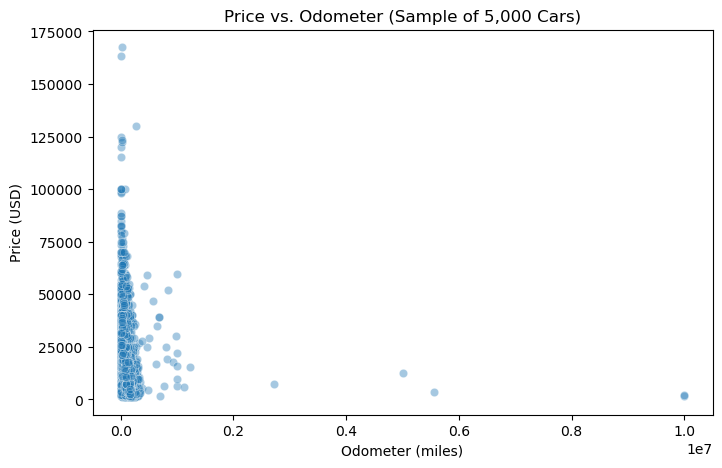

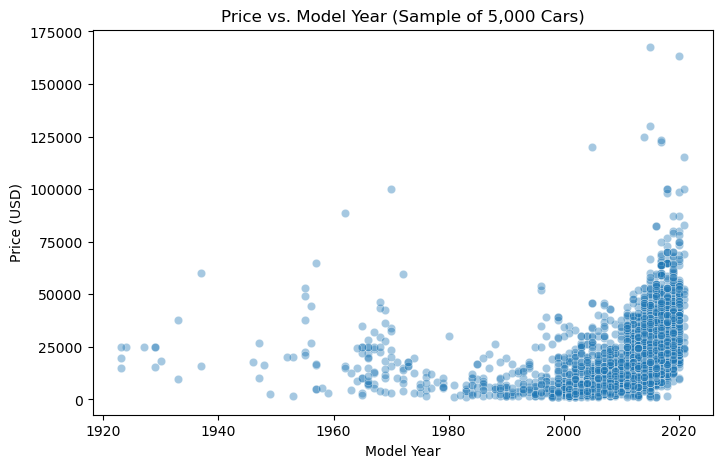

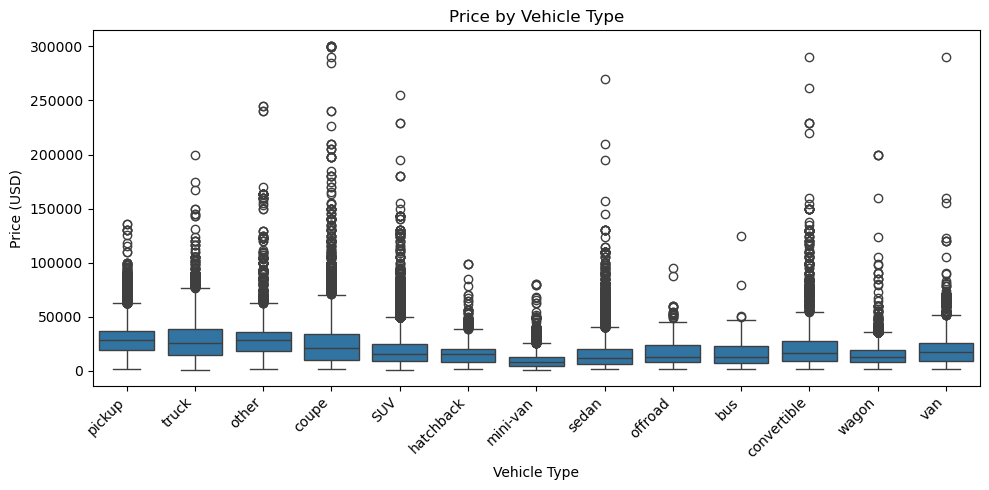

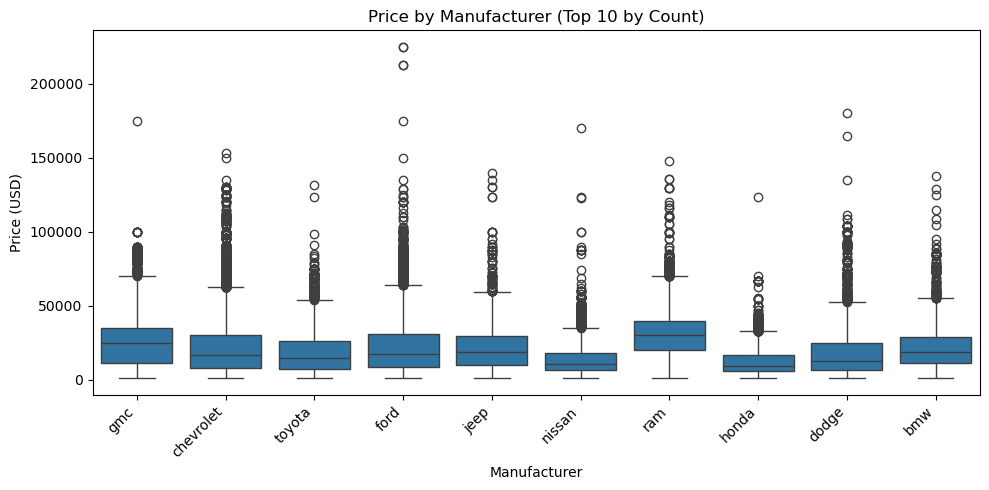

In [1]:
###### import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


data = pd.read_csv("vehicles.csv")
#data.info()

#checking data

#data['price'].info()
#data['price'].describe()
# keep only useful data
data = data.drop(columns=['id', 'VIN'])  

#checking for data type and values
data['price'].describe() # there several outliers
#data['price'].info()

#removing outlier (option 1)
data = data[(data['price'] > 1000) & (data['price'] <300000)]

#removing outlier with scaler (option 2)
#scaler = StandardScaler()
#z = scaler.fit_transform(data[['price']])
#data['z_price'] = z
#cleaned = data[np.abs(data['z_price']) < 3] 
#cleaned.describe()

#Max price in CLEANED: 64337
#Max price in X_train: 64337
#Max price in X_test: 64054
#Mean Squared Error: 106109256.87673976


#removing outlier with IQR (option 3)
#Q1 = data['price'].quantile(0.25)
#Q3 = data['price'].quantile(0.75)
#IQR = Q3 - Q1
#lower = Q1 - 1.5 * IQR
#upper = Q3 + 1.5 * IQR
#cleaned = data[(data['price'] >= lower) & (data['price'] <= upper)]
#Mean Squared Error: 96977161.42484367

#Model A: numeric only. simple regression 
df_A = data[['year', 'odometer', 'price']].dropna(subset=['year', 'odometer', 'price'])

# 2. Define variants 
X_A = df_A[['year', 'odometer']]
y_A = df_A['price']

# 3. Train / test split
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(
    X_A, y_A, test_size=0.2, random_state=42)

# 4. Pipeline with imputer + LinearRegression
model_A = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('lr', LinearRegression())])

model_A.fit(X_train_A, y_train_A)
pred_A = model_A.predict(X_test_A)

mse_A = mean_squared_error(y_test_A, pred_A)
rmse_A = np.sqrt(mse_A)
print("MSE :", mse_A)
print("RMSE:", rmse_A)
#MSE : 199349482.43524653
#RMSE: 14119.117622402844

# model B: set the variants, separating the numeric from categorical ones, adding poli, ridge and scaler (chosen)
numeric_cols = ['year', 'odometer']
#categorical_cols = ['manufacturer','condition','cylinders','fuel','drive','type','state','model']
categorical_cols = ['condition','cylinders','fuel','drive','type','state']
#set/create the transformer for both data types

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#combine both into one

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

#create the model with pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
    ('ridge', Ridge(alpha=1.0))])

# set X and y
X = data[numeric_cols + categorical_cols]
y = data['price']

#split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit the model

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)

print("MSE :", mse)
print("RMSE:", rmse)

#Cross validation

cv_scores = cross_val_score(
    model, X, y, cv=5, scoring='neg_mean_squared_error')

cv_rmse = np.sqrt(-cv_scores)

print("Cross-Validation RMSE for 5 folds:")
print(cv_rmse)
print("Average RMSE:", cv_rmse.mean())

#Grid search

param_grid = {'ridge__alpha': [0.1, 1, 10, 50, 100]}

grid = GridSearchCV(
    model,
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_)
print("Best MSE:", -grid.best_score_)
print("Best RMSE:", np.sqrt(-grid.best_score_))

#Use the fitted best model from grid search
best_model = grid.best_estimator_

#Grab the one-hot encoder for categorical features
onehot = (
    best_model.named_steps['preprocessor']
              .named_transformers_['cat']
              .named_steps['onehot'])

#Get names of all categorical dummy columns
cat_features = onehot.get_feature_names_out(categorical_cols)

#Get all Ridge coefficients
all_coefs = best_model.named_steps['ridge'].coef_

cat_coefs = all_coefs[-len(cat_features):]

#Build a clean coefficient table for categorical features
coef_df = (
    pd.DataFrame({
        'feature': cat_features,
        'coefficient': cat_coefs}).sort_values(by='coefficient', ascending=False))

print("\nTop 15 positive categorical coefficients:")
display(coef_df.head(15))

print("\nTop 15 negative categorical coefficients:")
display(coef_df.tail(15))

#Pareto chart to show the most sold cars (make/model)
data["make_model"] = data["manufacturer"] + " " + data["model"]
counts = data["make_model"].value_counts().head(20)  
cumulative = counts.cumsum() / counts.sum() * 100
fig, ax1 = plt.subplots(figsize=(14,6))

# Bar Chart (Counts)
ax1.bar(counts.index, counts.values, color="lightgreen")
ax1.set_xlabel("Car Make & Model")
ax1.set_ylabel("Count", color="green")
ax1.tick_params(axis='x', rotation=75)

#Second Axis for cumulative
ax2 = ax1.twinx()
ax2.plot(counts.index, cumulative.values, color="red", marker="o")
ax2.set_ylabel("Cumulative Percent (%)", color="red")
ax2.set_ylim(0, 110)

# Title
plt.title("Pareto Chart – Top 20 Most Sold Car Make & Model")

plt.tight_layout()
plt.show()
plt.figure(figsize=(8,5))
sns.histplot(data['price'], bins=50, kde=True)
plt.title("Distribution of Car Prices")
plt.xlabel("Price (USD)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=data.sample(5000, random_state=42), x='odometer', y='price', alpha=0.4)
plt.title("Price vs. Odometer (Sample of 5,000 Cars)")
plt.xlabel("Odometer (miles)")
plt.ylabel("Price (USD)")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=data.sample(5000, random_state=42), x='year', y='price', alpha=0.4)
plt.title("Price vs. Model Year (Sample of 5,000 Cars)")
plt.xlabel("Model Year")
plt.ylabel("Price (USD)")
plt.show()


plt.figure(figsize=(10,5))
sns.boxplot(data=data, x='type', y='price')
plt.xticks(rotation=45, ha='right')
plt.title("Price by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()


top_makes = data['manufacturer'].value_counts().head(10).index
subset = data[data['manufacturer'].isin(top_makes)]

plt.figure(figsize=(10,5))
sns.boxplot(data=subset, x='manufacturer', y='price')
plt.xticks(rotation=45, ha='right')
plt.title("Price by Manufacturer (Top 10 by Count)")
plt.xlabel("Manufacturer")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()
